In [18]:
import sys
import os
from dotenv import load_dotenv

import numpy as np
import pandas as pd
import sqlalchemy as sq
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
from imblearn.over_sampling import RandomOverSampler

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc

import tensorflow
from tensorflow import keras
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense



sys.path.append("../Shared/")
from DataService import DataService

In [7]:
from Datasets.DataCreation import getDatasetV1

# fetch data from db

In [8]:
df = getDatasetV1()
df.drop(columns=['year', 'district'], inplace=True)

In [ ]:
# function to update logs
def updateLog(fileName: str, message: str) -> None:
    try:
        if fileName is not None:
            with open(fileName, "a") as log:
                log.write(message + "\n")
    except Exception as e:
        print(message)

In [ ]:
LOG_FILE = "/data/pull_moisture.log"

load_dotenv()
PG_USER = os.getenv("POSTGRES_USER")
PG_PW = os.getenv("POSTGRES_PW")
PG_DB = os.getenv("POSTGRES_DB")
PG_ADDR = os.getenv("POSTGRES_ADDR")
PG_PORT = os.getenv("POSTGRES_PORT")

In [ ]:
if (
    PG_DB is None
    or PG_ADDR is None
    or PG_PORT is None
    or PG_USER is None
    or PG_PW is None
):
    updateLog(LOG_FILE, "Missing database credentials")
    raise ValueError("Environment variables are not set")
else:
    # connicting to database
    db = DataService(PG_DB, PG_ADDR, int(PG_PORT), PG_USER, PG_PW)
    conn = db.connect()

In [ ]:
# pulling soil moisture data
query = sq.text("select * FROM public.agg_soil_moisture")
sm_df = pd.read_sql(query, conn)

In [ ]:
sm_df.drop(columns=["index", "cr_num", "month", "day"], inplace=True)
sm_df.head()
# sm_df.duplicated().sum() # 0
# print(sm_df.shape) #117221

In [ ]:
# sm_df = sm_df.drop_duplicates()

In [ ]:
sm_df.shape

In [ ]:
# pull ergot data
query = sq.text("select * FROM public.agg_ergot_samples")
ergot_df = pd.read_sql(query, conn)

In [ ]:
ergot_df.shape

In [ ]:
ergot_df.sample(5)

In [ ]:
ergot_df["has_ergot"].value_counts()

In [ ]:
ergot_df.drop(columns=["sum_severity", "present_in_neighbor", "severity_in_neighbor", "percnt_true"], inplace=True)

In [ ]:
ergot_df.duplicated().sum()

In [ ]:
ergot_df = ergot_df.drop_duplicates()

In [ ]:
ergot_df.sample(5)

In [ ]:
ergot_df.shape

In [ ]:
# pull weather data
# in case reading csv
weather_df = pd.read_csv("data/aggregatedDly.csv")
weather_df.shape

In [ ]:
weather_df

In [ ]:
weather_df.drop(weather_df.columns[0], axis=1, inplace=True)

In [ ]:
all_col = weather_df.columns.tolist()
uni_col = set()
for i in range (2,len(all_col)):
    # print(all_col[i].split(":")[1])
    split_attr_name = all_col[i].split("_")
    if "mean" in split_attr_name[0]:
        uni_col.add(all_col[i].split(":")[1])

In [ ]:
uni_col

In [ ]:
new_weather_df = pd.DataFrame()
new_weather_df["year"] = weather_df["year"]
new_weather_df["district"] = weather_df["district"]
for col_name in uni_col:
    # col_name = "max_temp"
    fil_col = weather_df.filter(like=col_name)
    new_weather_df[col_name] = fil_col.mean(axis=1)
    # weather_df.drop(columns=fil_col.columns, inplace=True)


In [ ]:
weather_df.head()

In [ ]:
new_weather_df

In [ ]:
df = pd.merge(ergot_df, weather_df,  on=["year", "district"], how="left")

In [ ]:
df.isna().sum()

In [ ]:
df.interpolate(method="linear", limit_direction="both", inplace=True)

In [ ]:
df = pd.merge(df, sm_df, on=["year", "district"], how="left")

In [ ]:
df.isna().sum()

In [ ]:
df.interpolate(method="linear", limit_direction="both", inplace=True)

In [ ]:
df.shape

In [ ]:
# # joining tables
# # df = pd.merge(sm_df, ergot_df, how="inner", on=["year", "district"])
# df = pd.merge(sm_df, ergot_df)

In [ ]:
# df.shape

In [ ]:
# df = pd.merge(df, weather_df, on=["year", "district"])

In [ ]:
# df.shape

In [ ]:
df.info()

In [ ]:
df

In [ ]:
# temp = pd.merge(ergot_df, weather_df)
# temp.columns

In [ ]:
# g = sns.pairplot(temp.sample(1000))

In [ ]:
correlation_matrix = df.corr()
# Plot the correlation matrix as a heatmap
plt.figure(figsize=(30, 25))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True)
plt.title('Correlation Plot')
plt.show()

In [ ]:
# with the following function we can select highly correlated features
# it will remove the first feature that is correlated with anything other feature

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [ ]:
corr_features = correlation(df, 0.8)
len(set(corr_features))
corr_features

In [ ]:
# df.drop(columns=corr_features, inplace=True)

In [ ]:
# using one hot encoding to change catagorical variable to numarical
# df = pd.get_dummies(df, columns=["province"], drop_first=True)

In [ ]:
df.drop(columns=["year", "district"], inplace=True)

In [ ]:
df.columns

# split data

In [46]:
X = df.drop(columns=["has_ergot"])
y = df['has_ergot']
oversampler = RandomOverSampler(random_state=42)
# y = df['has_ergot'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=1, stratify=y)
# print(y_train.value_count())
X_train, y_train = oversampler.fit_resample(X_train, y_train)

In [47]:
y_train.value_counts()

True     696
False    696
Name: has_ergot, dtype: int64

In [48]:
X_train.columns

Index(['mean_total_precip', 'mean_snow_on_grnd', 'mean_total_rain',
       'mean_total_snow', 'mean_temp'],
      dtype='object')

In [49]:
# use StandardScaler when we don't know upper bounds
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [50]:
X_train_scaled.shape

(1392, 5)

In [51]:
tensorflow.config.set_visible_devices([], 'GPU')  # Hide GPU devices
tensorflow.config.set_visible_devices(tensorflow.config.list_physical_devices('CPU'), 'CPU')  # Show CPU devices


# creating model

In [52]:
model = Sequential()

model.add(Dense(5, activation="relu", input_dim = X.shape[1]))
model.add(Dense(4, activation="relu"))
# model.add(Dense(2, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
# model.add(Dense(1, activation="sigmoid", input_dim = X.shape[1]))

In [53]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 5)                 30        
                                                                 
 dense_8 (Dense)             (None, 4)                 24        
                                                                 
 dense_9 (Dense)             (None, 1)                 5         
                                                                 
Total params: 59
Trainable params: 59
Non-trainable params: 0
_________________________________________________________________


In [54]:
# compile model
model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=1e-3), metrics=["accuracy"])

In [55]:
history = model.fit(X_train_scaled, y_train, epochs=10000, validation_split=0.2, shuffle=True, batch_size=32)

Epoch 1/10000
35/35 [==============================] - 0s 4ms/step - loss: 0.7616 - accuracy: 0.4465 - val_loss: 0.6099 - val_accuracy: 0.6416
Epoch 2/10000
35/35 [==============================] - 0s 1ms/step - loss: 0.7128 - accuracy: 0.5040 - val_loss: 0.6600 - val_accuracy: 0.4086
Epoch 3/10000
35/35 [==============================] - 0s 1ms/step - loss: 0.6946 - accuracy: 0.5535 - val_loss: 0.6884 - val_accuracy: 0.3082
Epoch 4/10000
35/35 [==============================] - 0s 1ms/step - loss: 0.6862 - accuracy: 0.5885 - val_loss: 0.7085 - val_accuracy: 0.2222
Epoch 5/10000
35/35 [==============================] - 0s 1ms/step - loss: 0.6816 - accuracy: 0.6164 - val_loss: 0.7266 - val_accuracy: 0.1828
Epoch 6/10000
35/35 [==============================] - 0s 2ms/step - loss: 0.6783 - accuracy: 0.6262 - val_loss: 0.7391 - val_accuracy: 0.1685
Epoch 7/10000
35/35 [==============================] - 0s 1ms/step - loss: 0.6758 - accuracy: 0.6379 - val_loss: 0.7527 - val_accuracy: 0.1685

In [56]:
model.weights

[<tf.Variable 'dense_7/kernel:0' shape=(5, 5) dtype=float32, numpy=
 array([[-0.35406014, -1.1217784 ,  0.44230825,  0.67335   , -0.7172039 ],
        [ 1.9723725 ,  0.32143858,  0.16504091,  0.8902001 ,  1.2296773 ],
        [-0.5260211 ,  0.73389584,  0.30579692, -0.79245037,  0.29689682],
        [-0.20053571,  0.43269742,  0.24934876, -0.02689626, -0.24557354],
        [-0.80638206,  0.6739773 , -0.24240825, -0.24106039, -0.5082538 ]],
       dtype=float32)>,
 <tf.Variable 'dense_7/bias:0' shape=(5,) dtype=float32, numpy=
 array([ 1.4083841 , -0.2652037 ,  0.6466151 ,  0.78525645,  0.37718025],
       dtype=float32)>,
 <tf.Variable 'dense_8/kernel:0' shape=(5, 4) dtype=float32, numpy=
 array([[-1.5810108 ,  1.1076094 ,  0.90561783,  1.075009  ],
        [ 1.3116128 , -0.16355675,  0.48457497,  0.57668436],
        [ 0.27385575,  0.5682763 , -0.02286762, -0.02868673],
        [ 1.1099938 , -1.1018755 , -1.5075215 , -1.7918907 ],
        [ 1.6730782 , -1.0516034 , -1.3169937 , -1.565

In [57]:
y_pred = model.predict(X_test_scaled)

7/7 [==============================] - 0s 656us/step


In [58]:
threshhold = 0.8
y_pred = np.where(y_pred > threshhold, True, False)

# y_test = y_test.to_numpy()
# type(y_pred)

In [59]:
accuracy_score(y_test, y_pred)

0.4694835680751174

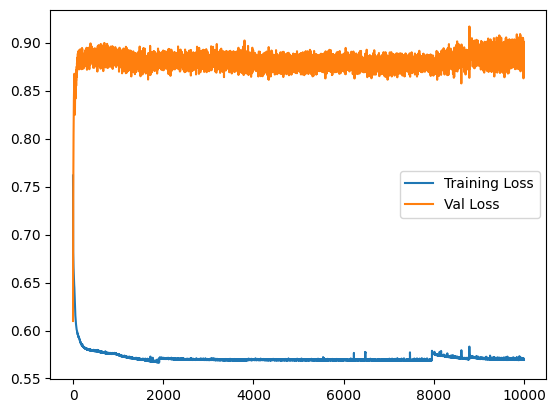

In [60]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()

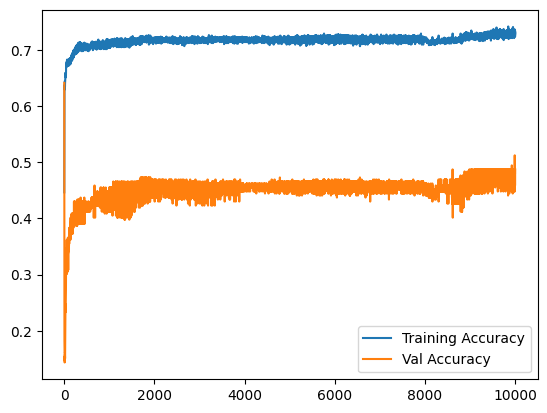

In [61]:
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.legend()

In [62]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.18      0.54      0.27        39
        True       0.81      0.45      0.58       174

    accuracy                           0.47       213
   macro avg       0.50      0.50      0.43       213
weighted avg       0.70      0.47      0.53       213



0.4962422634836428


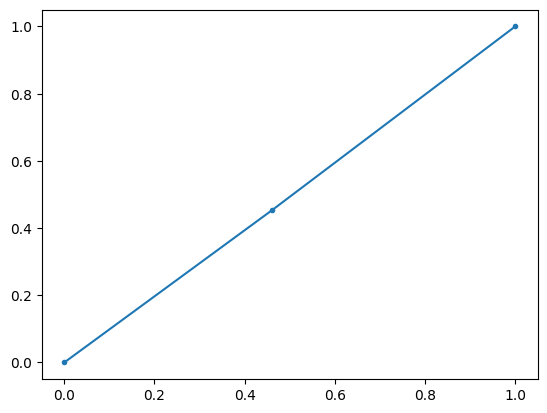

In [63]:
fpr, tpr, t = roc_curve(y_test, y_pred)
auc_ = auc(fpr, tpr)
plt.plot(fpr, tpr, marker=".")
print(auc_)

In [64]:
# prints weight with attribute
attributes = X_train.columns.tolist()
weights = model.layers[0].get_weights()[0]
bias = model.layers[0].get_weights()[1]

result = {}

for x, y in zip(attributes, weights):
    result[x] = y

result = pd.DataFrame(result)

result.transpose()
print(result.max())

mean_total_precip    0.673350
mean_snow_on_grnd    1.972373
mean_total_rain      0.733896
mean_total_snow      0.432697
mean_temp            0.673977
dtype: float32
